The scripts below demonstrate how to use EPCOT to predict epigenomic features, CAGE-seq, chromatin contact maps, and enhancer activity.

We run EPCOT on Google Colab notebook under GPU setting : Runtime -> Change runtime type -> select GPU

In [1]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
!pip install einops
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### clone our GitHub repo
!git clone https://github.com/liu-bioinfo-lab/EPCOT.git
!mkdir models

Cloning into 'EPCOT'...
remote: Enumerating objects: 1145, done.
remote: Counting objects: 100% (351/351), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1145 (delta 206), reused 285 (delta 169), pack-reused 794
Receiving objects: 100% (1145/1145), 73.32 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [3]:
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import argparse
import sys,os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
sys.path.append('EPCOT/')
from usage_util import *
from pretraining.model import build_model
sys.path.append('EPCOT/GEP/')
from cage.model import build_pretrain_model_cage
sys.path.append('EPCOT/COP/')
from hic.model import build_pretrain_model_hic
from microc.model import build_pretrain_model_microc

### Download and index reference genome file

In [4]:
### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = '/root/data/genome.fa'
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data
class FastaStringExtractor:
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
fasta_extractor = FastaStringExtractor(fasta_file)

--2022-06-26 05:20:54--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  19.7MB/s    in 49s     

2022-06-26 05:21:44 (19.0 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


### Download example input DNase-seq tracks and EPCOT trained models

The inputs to EPCOT are RPGC normalized DNase-seq or ATAC-seq. For how to generate the input DNase-seq, please see [our GitHub repo](https://github.com/liu-bioinfo-lab/EPCOT/tree/main/Data).

In [5]:
### The DNase-seq tracks are saved as python dictionary structure where the keys are chromosomes and values are sparse matrix of DNase-seq.
!gdown 1MWZEktc6OjX2staP2YDtYafFnWHv5afm --output stomach_f53_dnase.pickle
!gdown 1g4QEEppXxMohrrmsQdcXGBejznZIZaVA --output hff_dnase.pickle
!gdown 1XEvDzsLPN6cmJPcV5y4XS1DQmLqOZ1aR --output tibial_nerve_m37_dnase.pickle
!gdown 1oYTU35UmyO7G-i_ulNW3uCELJaKkElhQ --output transverse_colon_m37_dnase.pickle
### download example DNase-seq in chromosome 11
GM12878_dnase=load_npz('EPCOT/examples/GM12878_dnase_chr11.npz').toarray().squeeze()
HCT116_dnase=load_npz('EPCOT/examples/HCT116_dnase_chr11.npz').toarray().squeeze()
HUVEC_dnase=load_npz('EPCOT/examples/HUVEC_dnase_chr11.npz').toarray().squeeze()
IMR90_dnase=load_npz('EPCOT/examples/IMR-90_dnase_chr11.npz').toarray().squeeze()
HepG2_dnase=load_npz('EPCOT/examples/HepG2_dnase_chr11.npz').toarray().squeeze()

Downloading...
From: https://drive.google.com/uc?id=1MWZEktc6OjX2staP2YDtYafFnWHv5afm
To: /content/stomach_f53_dnase.pickle
100% 893M/893M [00:08<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g4QEEppXxMohrrmsQdcXGBejznZIZaVA
To: /content/hff_dnase.pickle
100% 1.48G/1.48G [00:13<00:00, 109MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1XEvDzsLPN6cmJPcV5y4XS1DQmLqOZ1aR
To: /content/tibial_nerve_m37_dnase.pickle
100% 824M/824M [00:07<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oYTU35UmyO7G-i_ulNW3uCELJaKkElhQ
To: /content/transverse_colon_m37_dnase.pickle
100% 755M/755M [00:08<00:00, 91.9MB/s]


In [12]:
### pre-training model
!gdown 1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz --output models/pretrain_dnase.pt
### pre-training models trained on ATAC-seq 
# !gdown 1aMb3kVmaWZPUzqKmfZs9xWT-QLUGjQQd --output models/pretrain_atac.pt

### CAGE-seq GEP
!gdown 1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF --output models/cage_transformer.pt

### Hi-C COP
### Models trained on different cell/tissue types
!gdown 1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW --output models/hic_GM12878_transformer.pt
!gdown 1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH --output models/hic_HFF_transformer.pt
!gdown 1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm --output models/hic_IMR-90_transformer.pt
!gdown 1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA --output models/hic_trans_colon_m37_transformer.pt
### models trained on ATAC-seq
# !gdown 1Lyfpn9YOscMbYCp79F3BDrlOSX77Q_P_ --output models/GM12878_hic_atac.pt
# !gdown 1L6Woz9gqZa_bkuZFJj3FzJ41RW79zSav --output trans_colon_m37_hic_atac.pt
### CTCF ChIA-PET
!gdown 1DW1K8L3EXfbliyxJ0hgKSLamy_w0YNEC --output models/GM12878_CTCF_chiapet.pt
### Micro-C COP
!gdown 1D8ue_YiljdNqcpIM5xIcJ7fUfREczbEq --output models/HFF_microc.pt

Downloading...
From: https://drive.google.com/uc?id=1_YfpNSv-2ABQV2qSyBxem-y7aJFyRNzz
To: /content/models/pretrain_dnase.pt
100% 100M/100M [00:00<00:00, 258MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1eP-ruOcywlGeQIRuVwWk_QFc4z9j4-jF
To: /content/models/cage_transformer.pt
100% 119M/119M [00:02<00:00, 58.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EXm2AjqqO-UtLi2pprbDEb1gPXrxI3aW
To: /content/models/hic_GM12878_transformer.pt
100% 119M/119M [00:01<00:00, 67.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ia-ZoSoiZGDFPnZcySzMpirovHhulRfH
To: /content/models/hic_HFF_transformer.pt
100% 119M/119M [00:00<00:00, 240MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ofkpS526gXpnusGpRWVHgIFFFpTSW4Rm
To: /content/models/hic_IMR-90_transformer.pt
100% 119M/119M [00:00<00:00, 319MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1OtWkTLuYad3iRPuGy5OCewNGPlr47ogA
To: /content/models/hic_trans_colon_m37_transformer.pt
100% 119M/119M [00:0

### Model parameters

In [13]:
### arguments for pre-training model
def parser_args():
    parser = argparse.ArgumentParser(add_help=False)
    parser.add_argument('--num_class', default=245, type=int)
    parser.add_argument('--seq_length', default=1600, type=int)
    parser.add_argument('--embedsize', default=320, type=int)
    parser.add_argument('--nheads', default=4, type=int)
    parser.add_argument('--hidden_dim', default=512, type=int)
    parser.add_argument('--dim_feedforward', default=1024, type=int)
    parser.add_argument('--enc_layers', default=1, type=int)
    parser.add_argument('--dec_layers', default=2, type=int)
    parser.add_argument('--dropout', default=0.2, type=float)
    parser.add_argument('--fea_pos', default=False, action='store_true')
    parser.add_argument('--load_backbone', default=False)
    args, unknown = parser.parse_known_args()
    return args,parser
def get_args():
    args,_ = parser_args()
    return args,_
### arguments for downstream model to predict 1kb-resolution CAGE-seq
def parser_args_cage(parent_parser):
    parser=argparse.ArgumentParser(parents=[parent_parser])
    parser.add_argument('--bins', type=int, default=250)
    parser.add_argument('--crop', type=int, default=25)
    parser.add_argument('--pretrain_path', type=str, default='none')
    parser.add_argument('--embed_dim', default=360, type=int)
    parser.add_argument('--mode', type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args
### arguments for downstream model to predict 5kb-resolution Hi-C and ChIA-PET
def parser_args_hic(parent_parser):
    parser=argparse.ArgumentParser(parents=[parent_parser])
    parser.add_argument('--bins', type=int, default=200)
    parser.add_argument('--crop', type=int, default=4)
    parser.add_argument('--pretrain_path', type=str, default='none')
    parser.add_argument('--embed_dim', default=256, type=int)
    parser.add_argument('--trunk',  type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args
### arguments for downstream model to predict 1kb-resolution Micro-C
def parser_args_microc(parent_parser):
    parser=argparse.ArgumentParser(parents=[parent_parser])
    parser.add_argument('--bins', type=int, default=600)
    parser.add_argument('--crop', type=int, default=50)
    parser.add_argument('--pretrain_path', type=str, default='none')
    parser.add_argument('--embed_dim', default=256, type=int)
    parser.add_argument('--trunk',  type=str, default='transformer')
    parser.add_argument('--fine_tune', default=False, action='store_true')
    args, unknown = parser.parse_known_args()
    return args

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args,parser = get_args()
cage_args=parser_args_cage(parser)
hic_args=parser_args_hic(parser)
microc_args=parser_args_microc(parser)

## Examples of predicting multiple modalities in GM12878 cell line

You can replace GM12878 DNase-seq with your own DNase-seq as model input, please see the 'cross-cell/tissue type prediction' section for examples of predicting on DNase-seq of new cell/tissue types.

### Epigenomic feature prediction (EFP task)

In [14]:
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
### load pre-training model
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))

<All keys matched successfully>

In [15]:
### region of interest, the start and end position should be divisible by 1000
chrom,start,end=['chr11',46750000,47750000]
pred_score_epi=predict_epis(pretrain_model,chrom, start,end,GM12878_dnase,fasta_extractor)
pred_score_epi.shape

(1000, 245)

CTCF


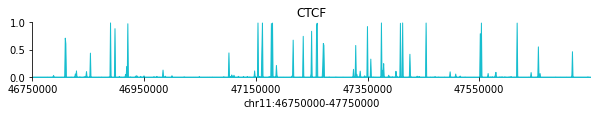

In [16]:
### a list of epigenome features predicted by EPCOT
with open('EPCOT/Profiles/epigenomes.txt', 'r') as f:
    epigenomes = f.read().splitlines()
### choose the index of epigenome feature of interest 
epi_idx=0
print(epigenomes[epi_idx])
### plot results
fig,ax=plt.subplots(figsize=(10,1))
val=pred_score_epi[:,0]
plot_bindings(ax,val, chrom,start,end)
ax.set_title(epigenomes[epi_idx])
ax.set_xlabel('%s:%s-%s'%(chrom,start,end))
plt.show()

### Downstream model to predict CAGE-seq (CAGE-seq GEP task)

The downstream model to predict 1kb-resolution CAGE-seq takes the input of 250kb genomic regions and predicts the CAGE-seq in the centered 200kb region.

In [17]:
cage_model= build_pretrain_model_cage(cage_args)
cage_model.to(device)
cage_model.eval()
### load trained model
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))

### enter region of interest ('cage_end-cage_start' should be divisible by 200000)
cage_chrom,cage_start,cage_end=['chr11',46750000,47750000]
pred_cage=predict_cage(cage_model,cage_chrom,cage_start,cage_end,GM12878_dnase,fasta_extractor)
pred_cage.shape

EPCOT/GEP/cage/layers.py:65: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  log_normalization = (torch.lgamma(concentration) - concentration * torch.log(rate))


(1000,)

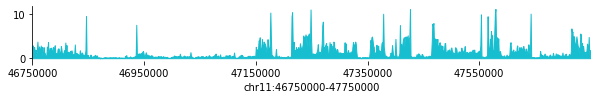

In [18]:
### plot results
fig,ax=plt.subplots(figsize=(10,1))
plot_cage(ax,pred_cage,cage_chrom,cage_start,cage_end)

### Hi-C chromatin contact map prediction (Hi-C COP task)
In Hi-C prediction, we predict the upper triangular of contact matrices in the centered 960kb region of the input 1Mb region

In [19]:
### arguments for hic downstream model
hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()
hic_model.eval()
### load GM12878 model
hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))

61


<All keys matched successfully>

(1, 18528, 1)


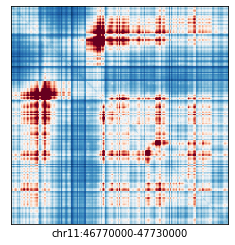

In [20]:
### regions of interest (input a 1Mb region where 'hic_end-hic_start' should be equal 1000000)
### the output is an array of the upper triangular of the contact matrix
hic_chrom,hic_start,hic_end=['chr11',46750000,47750000]
pred_hic=predict_hic(hic_model,hic_chrom,hic_start,hic_end,GM12878_dnase,fasta_extractor)
print(pred_hic.shape)
### convert the upper triangular array into a contact matrix
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))
### plot
fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=5)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

### ChIA-PET contact map prediction
The model architecture to predict ChIA-pet is the same as that in Hi-C contact map prediction

In [21]:
hic_model_chiapet= build_pretrain_model_hic(hic_args)
hic_model_chiapet.cuda()
hic_model_chiapet.eval()
hic_model_chiapet.load_state_dict(torch.load('models/GM12878_CTCF_chiapet.pt'))

61


<All keys matched successfully>

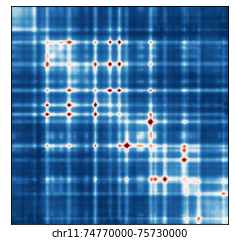

In [22]:
### regions of interest
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]
pred_hic=predict_hic(hic_model_chiapet,hic_chrom,hic_start,hic_end,GM12878_dnase,fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))

fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

# Cross-cell/tissue type prediction

If the input DNase-seq has different distribution to our training DNase-seq, it may be helpful to add 

```
for m in model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
```
after ```model.eval()``` in COP tasks, which uses batch statistics instead of running statistics in batch normalization for inference.

## Examples of cross-cell type prediction in HCT116 and HUVEC

<!-- For cross-cell type prediction, it is important that the normalized DNase-seq in training cell types and testing cell types have similar data scales, if not, maybe some normalization methods are needed. -->

In [23]:
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
### load pre-training model
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))

cage_model= build_pretrain_model_cage(cage_args)
cage_model.to(device)
cage_model.eval()
cage_model.load_state_dict(torch.load('models/cage_transformer.pt'))

###  Hi-C cross-cell type predicition
###  load models trained on GM12878 and IMR-90
hic_model_gm= build_pretrain_model_hic(hic_args)
hic_model_gm.cuda()
hic_model_gm.eval()
hic_model_gm.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model_imr= build_pretrain_model_hic(hic_args)
hic_model_imr.cuda()
hic_model_imr.eval()
hic_model_imr.load_state_dict(torch.load('models/hic_IMR-90_transformer.pt'))

61
61


<All keys matched successfully>

Functions ```predict_epis```, ```predict_cage```, ```predict_hic```, and ```predict_microc``` have following arguments
* ```model```: the model used to predict each of the modalities
* ```chrom```, ```start```, ```end``` : chromosome, start position, end position of the input genomic region
* ```dnase``` : DNase-seq of cell type of interest. You can input your own DNase-seq  to make predictions.

In [24]:
###  cross-cell type epigenomic feature prediction
###  region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(model=pretrain_model,
                       chrom=chrom,start=start,end=end,
                       dnase=HCT116_dnase,
                       fasta_extractor=fasta_extractor)

###  Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(model=cage_model,
                        chrom=cage_chrom,start=cage_start,end=cage_end,
                        dnase=HCT116_dnase,
                        fasta_extractor=fasta_extractor)

###  cross-cell type contact map prediction using ensemble of models trained on GM12878 and IMR-90
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(model=hic_model_gm,
                      chrom=hic_chrom,start=hic_start,end=hic_end,
                      dnase=HCT116_dnase,
                      fasta_extractor=fasta_extractor)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HCT116_dnase,fasta_extractor)
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))

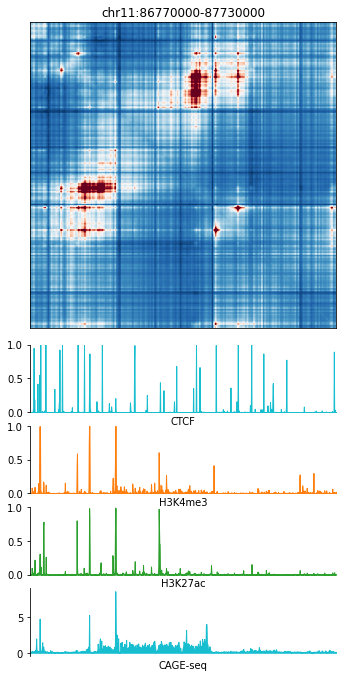

In [25]:
###  plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()

In [26]:
###  cross-cell type contact map prediction using ensemble of models trained on GM12878 and IMR-90
hic_chrom,hic_start,hic_end=['chr11',86750000,87750000]
pred_hic1=predict_hic(hic_model_gm,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor)
pred_hic2=predict_hic(hic_model_imr,hic_chrom,hic_start,hic_end,HUVEC_dnase,fasta_extractor)
pred_hic=(pred_hic1+pred_hic2)/2
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))

###  cross-cell type epigenomic feature prediction
###  region of interest
chrom,start,end=['chr11',86770000,87730000]
pred_epi= predict_epis(pretrain_model,chrom,start,end,HUVEC_dnase,fasta_extractor)

###  Cross-cell type CAGE-seq prediction
cage_chrom,cage_start,cage_end=['chr11',86750000,87750000]
pred_cage= predict_cage(cage_model,cage_chrom,cage_start,cage_end,HUVEC_dnase,fasta_extractor)

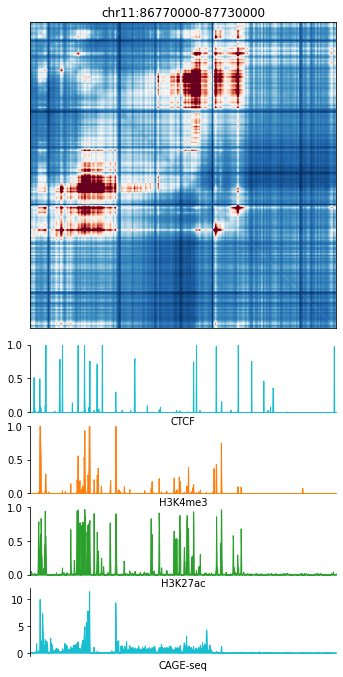

In [27]:
###  plot results
fig = plt.figure(figsize=(5, 9.5))
gs = GridSpec(8, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(4)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','H3K27ac','CAGE-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_bindings(ax_track[2],pred_epi[:,-6], chrom,start,end,color='tab:green')
plot_cage(ax_track[3],pred_cage[20:-20],cage_chrom,cage_start,cage_end)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start,end))
plt.show()

## Examples of cross-tissue type prediction in GTEx tissue donors

In [28]:
###  load DNase-seq of stomach tisssue (female 53)
import pickle
with open('stomach_f53_dnase.pickle','rb') as f:
    stomach_tmp_dnase=pickle.load(f)

Cross-tissue type contact map prediction here uses model trained on transverse colon (male 37 years) whose contact map is smoothed. You can also use models trained on ENCODE cell lines whose contact maps are not smoothed.

In [40]:
### cross-tissue type contact map prediction using model trained on transverse colon (male 37 years)
pretrain_model= build_model(args)
pretrain_model.to(device)
pretrain_model.eval()
pretrain_model.load_state_dict(torch.load('models/pretrain_dnase.pt'))


hic_model= build_pretrain_model_hic(hic_args)
hic_model.cuda()
hic_model.eval()
for m in hic_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
# hic_model.load_state_dict(torch.load('models/hic_GM12878_transformer.pt'))
hic_model.load_state_dict(torch.load('models/hic_trans_colon_m37_transformer.pt'))

chrom,start,end=['chr11',7750000,8750000]
stomach_dnase=stomach_tmp_dnase[int(hic_chrom[3:])].toarray().squeeze()
pred_hic=predict_hic(hic_model,chrom,start,end,stomach_dnase,fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))

pred_epi= predict_epis(pretrain_model,chrom,start+20000,end-20000,stomach_dnase,fasta_extractor)

61


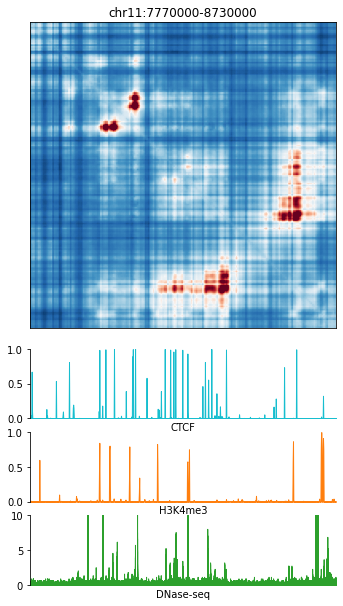

In [41]:
fig = plt.figure(figsize=(5, 8.5))
gs = GridSpec(7, 5, wspace = 0.75, hspace = 0.2, left = 0.05, top = 0.98, right = 0.9, bottom = 0.05)
ax_hic = fig.add_subplot(gs[:4, :5])
ax_track= [fig.add_subplot(gs[4+i:5+i,:5]) for i in range(3)]
plot_hic(ax_hic,pred_hic_mat,vmin=0,vmax=4)
epis=['CTCF','H3K4me3','DNase-seq']
plot_bindings(ax_track[0],pred_epi[:,0], chrom,start,end)
plot_bindings(ax_track[1],pred_epi[:,-3], chrom,start,end,color='tab:orange')
plot_cage(ax_track[2],stomach_dnase[start:end],chrom,start,end,color='tab:green')
ax_track[2].set_ylim(0,10)
for i in range(len(ax_track)):
  ax_track[i].set_xticks([])
  ax_track[i].set_xlabel(epis[i])
ax_hic.set_title('%s:%s-%s'%(chrom,start+20000,end-20000))
plt.show()

## Cross-cell type ChIA-pet prediction 

In [31]:
hic_model_chiapet= build_pretrain_model_hic(hic_args)
hic_model_chiapet.cuda()
hic_model_chiapet.eval()
for m in hic_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()
hic_model_chiapet.load_state_dict(torch.load('models/GM12878_CTCF_chiapet.pt'))

61


<All keys matched successfully>

In [32]:
import pickle
with open('hff_dnase.pickle','rb') as f:
    hff_tmp_dnase=pickle.load(f)

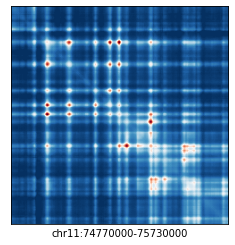

In [33]:
### the model trained on GM12878 is transferred to HFF cell line
hic_chrom,hic_start,hic_end=['chr11',74750000,75750000]
hff_dnase=hff_tmp_dnase[hic_chrom[3:]].toarray().squeeze()
pred_hic=predict_hic(hic_model_chiapet,hic_chrom,hic_start,hic_end,hff_dnase,fasta_extractor)
pred_hic_mat=complete_mat(arraytouptri(pred_hic[0].squeeze(),hic_args))

fig,ax=plt.subplots()
plot_hic(ax,pred_hic_mat,vmin=0,vmax=3)
ax.set_xlabel('%s:%s-%s'%(hic_chrom,hic_start+20000,hic_end-20000))
plt.show()

## Micro-C contact map prediction 

In Micro-C prediction, we predict the upper triangular of contact matrices in the centered 500kb region of the input 600kb region

61


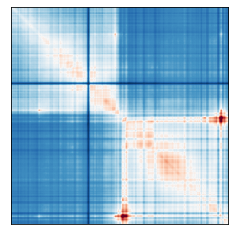

In [34]:
microc_model= build_pretrain_model_microc(microc_args)
microc_model.cuda()
microc_model.load_state_dict(torch.load('models/HFF_microc.pt'))
microc_model.eval()
microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
hff_dnase=hff_tmp_dnase[hic_chrom[3:]].toarray().squeeze()
pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,hff_dnase,fasta_extractor)
pred_microc=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))
fig,ax=plt.subplots()
plot_hic(ax,pred_microc,vmin=-2,vmax=2)

## Cross-cell/tissue type Micro-C contact map prediction 

In [35]:
### load DNase-seq of the two tissues
with open('tibial_nerve_m37_dnase.pickle','rb') as f:
    tbn_tmp_dnase=pickle.load(f)
with open('transverse_colon_m37_dnase.pickle','rb') as f:
    trans_colon_dnase=pickle.load(f)

In [36]:
microc_model= build_pretrain_model_microc(microc_args)
microc_model.cuda()
microc_model.load_state_dict(torch.load('models/HFF_microc.pt'))
for m in microc_model.modules():
    if m.__class__.__name__.startswith('BatchNorm'):
        m.train()

61


In [37]:
### regions of interest
microc_chrom,microc_start,microc_end=['chr11',113000000,113600000]
# microc_chrom,microc_start,microc_end=['chr11',67000000,67600000]
tbn_dnase=tbn_tmp_dnase[int(microc_chrom[3:])].toarray().squeeze()
tc_dnase=trans_colon_dnase[int(microc_chrom[3:])].toarray().squeeze()
stomach_dnase=stomach_tmp_dnase[int(microc_chrom[3:])].toarray().squeeze()
pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,HUVEC_dnase,fasta_extractor)
pred_microc_huvec=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,HCT116_dnase,fasta_extractor)
pred_microc_hct116=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,GM12878_dnase,fasta_extractor)
pred_microc_gm12878=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,HepG2_dnase,fasta_extractor)
pred_microc_hepg2=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,IMR90_dnase,fasta_extractor)
pred_microc_imr90=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,stomach_dnase,fasta_extractor)
pred_microc_stomach=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,tbn_dnase,fasta_extractor)
pred_microc_tbn=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

pred_microc=predict_microc(microc_model,microc_chrom,microc_start,microc_end,tc_dnase,fasta_extractor)
pred_microc_tc=complete_mat(arraytouptri(pred_microc[0].squeeze(),microc_args))

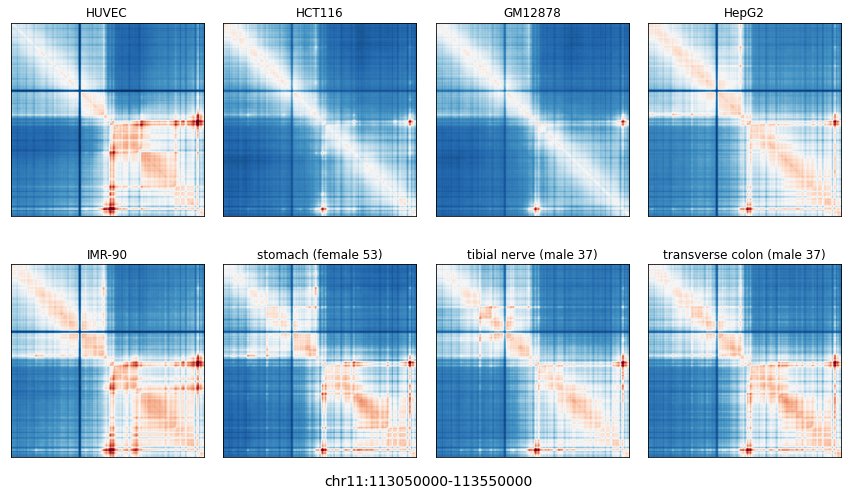

In [38]:
cells=['HUVEC','HCT116','GM12878','HepG2','IMR-90','stomach (female 53)', 'tibial nerve (male 37)','transverse colon (male 37)']
fig,axs=plt.subplots(2,4,figsize=(12,7))
microc_mat=[pred_microc_huvec,pred_microc_hct116,pred_microc_gm12878,pred_microc_hepg2,pred_microc_imr90,pred_microc_stomach,pred_microc_tbn,pred_microc_tc]
for i in range(2):
    for j in range(4):
        plot_hic(axs[i,j],microc_mat[i*4+j],vmin=-2,vmax=2)
        axs[i,j].set_title(cells[i*4+j])
fig.text(0.5,0.01,'%s:%s-%s'%(microc_chrom,microc_start+50000,microc_end-50000),fontsize=14,ha='center')
plt.tight_layout()
plt.show()

### the predicted Micro-C of HCT116 and GM12878 is not in the same scale with other cell/tissue types, so the scale needs to be adjusted in visualization